In [32]:
import json
import logging
import os
from typing import Union, List, Dict, Any

import numpy as np
import pandas as pd
from pandas import Timestamp
import matplotlib.pyplot as plt
import itertools
import pprint

In [33]:
logger = logging.getLogger(__name__)

logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

logger.setLevel(logging.INFO)

In [34]:
satellite_json: os.path = "../data/CubeBel-1/normalized_frames.json"

with open(satellite_json, 'r') as file:
    json_stream: str = file.read()

json_data: dict = json.loads(json_stream)

if not json_data:
    logger.error("Json data is empty")
    exit(1)


class Satellite:
    def __init__(self, norad_id: int, name: str, observations_amount: int):
        self.norad_id: int = norad_id
        self.name: str = name
        self.observations_amount: int = observations_amount


metadata: dict = json_data['metadata']

satellite: Satellite = Satellite(
    metadata['satellite_norad'],
    metadata['satellite_name'],
    metadata['total_frames']
)

# Note '...' means there might be more same data

# column_tags look like:
# "column_tags": {
#               "some_variable": "variable",
#               "some_constant": "constant",
#               ... 
#               "some_status": "status"
#             }
solar_and_satellite_parameters_names: Dict[str, str] = metadata['analysis'][
    'column_tags']

# feature_columns looks like:
# "feature_columns": [
#                 "Fredericksburg A",
#                 "Fredericksburg K 0-3"
#                 ]
solar_parameters_names: List[str] = metadata['analysis']['feature_columns']

satellite_parameters_names: List[str] = [value for value in
                                         solar_and_satellite_parameters_names if
                                         value not in solar_parameters_names]

# frames look like (fields might contain both satellite and solar parameters):
# "frames": [
#         {
#             "time": "2019-07-02 18:15:08",
#             "measurement": "",
#             "tags": {
#                 "satellite": "",
#                 "decoder": "Lightsail2",
#                 "station": "",
#                 "observer": "",
#                 "source": "",
#                 "version": "1.66.0"
#             },
#             "fields": {
#                 "dest_callsign": {
#                     "value": "N6CP  ",
#                     "unit": null
#                 },
#                 "Fredericksburg A": {
#                     "value": 3.3125,
#                     "unit": "V"
#                 },
#                 ...
#             }
#         },
#         ...
#     ]

frames: dict = json_data['frames']

allowed_types: Union = Union[int, float, bool, str]

observation_data: List[Dict[str, Timestamp]] = []

# 'time' is unix timestamps, convertor - https://www.epochconverter.com/
for frame in frames:
    observation_time = pd.to_datetime(frame['time'])
    fields: Dict[Any, Any] = {key: value['value'] for key, value in
                              frame['fields'].items() if
                              isinstance(value, dict)}
    observation_data.append({'time': observation_time, **fields})

observation_dataframe: pd.DataFrame = pd.DataFrame(observation_data).set_index(
    'time').dropna().select_dtypes(include=np.number)

observation_dataframe = observation_dataframe.loc[:,
                        observation_dataframe.nunique() > 1]  # Select columns with more than 1 unique value

In [35]:
solar_parameters_names = [param for param in solar_parameters_names if
                          param in observation_dataframe.columns]

satellite_parameters_names = [param for param in satellite_parameters_names if
                              param in observation_dataframe.columns]

In [36]:
def calculate_correlations(df: pd.DataFrame, list1_columns: List[str],
                           list2_columns: List[str]) -> Dict[str, float]:
    """
    Calculates Pearson correlation coefficients between columns in two lists from a DataFrame.
  
    Args:
        df (pd.DataFrame): DataFrame containing observations with potential missing values.
        list1_columns (list): List of column names from the first list.
        list2_columns (list): List of column names from the second list.
  
    Returns:
        dict: A dictionary containing correlation coefficients between corresponding pairs 
              of columns from the two lists.
    """
    corr_df: pd.DataFrame = df[list1_columns + list2_columns].corr()

    result: Dict[str, float] = {}

    for col1 in list1_columns:
        for col2 in list2_columns:
            if col1 != col2:
                result[f"{col1} vs. {col2}"] = corr_df.loc[col1, col2]

    return result


correlations: Dict[str, float] = calculate_correlations(observation_dataframe,
                                                        satellite_parameters_names,
                                                        solar_parameters_names)

sorted_correlations: Dict[str, float] = dict(
    sorted(correlations.items(), key=lambda item: abs(item[1]), reverse=True))

pprint.pprint(sorted_correlations, sort_dicts=False)

{'hdr_battery_voltage vs. Sunspot Area': -0.9616458816599319,
 'battery_voltage vs. Sunspot Area': -0.9613913377815557,
 'hdr_battery_voltage vs. Radio Flux': -0.9436264806220195,
 'battery_voltage vs. Radio Flux': -0.9431502017418005,
 'battery_voltage vs. X-Ray S': -0.9023885406290587,
 'hdr_battery_voltage vs. X-Ray S': -0.902383804053839,
 'hdr_battery_voltage vs. Planetary K 9-12': -0.8064442139253486,
 'battery_voltage vs. Planetary K 9-12': -0.8051863340220269,
 'hdr_battery_voltage vs. X-Ray C': -0.8011068402622575,
 'battery_voltage vs. X-Ray C': -0.8007795825999328,
 'battery_voltage vs. SESC sunspot number': -0.7726334952976461,
 'hdr_battery_voltage vs. SESC sunspot number': -0.7722806894684022,
 'hdr_battery_voltage vs. Planetary K 18-21': -0.7687005064509488,
 'battery_voltage vs. Planetary K 18-21': -0.7684234636980343,
 'sys_voltage_33 vs. Sunspot Area': 0.7471556887207657,
 'hdr_battery_voltage vs. College K 21-24': -0.7464256183575562,
 'battery_voltage vs. College K 

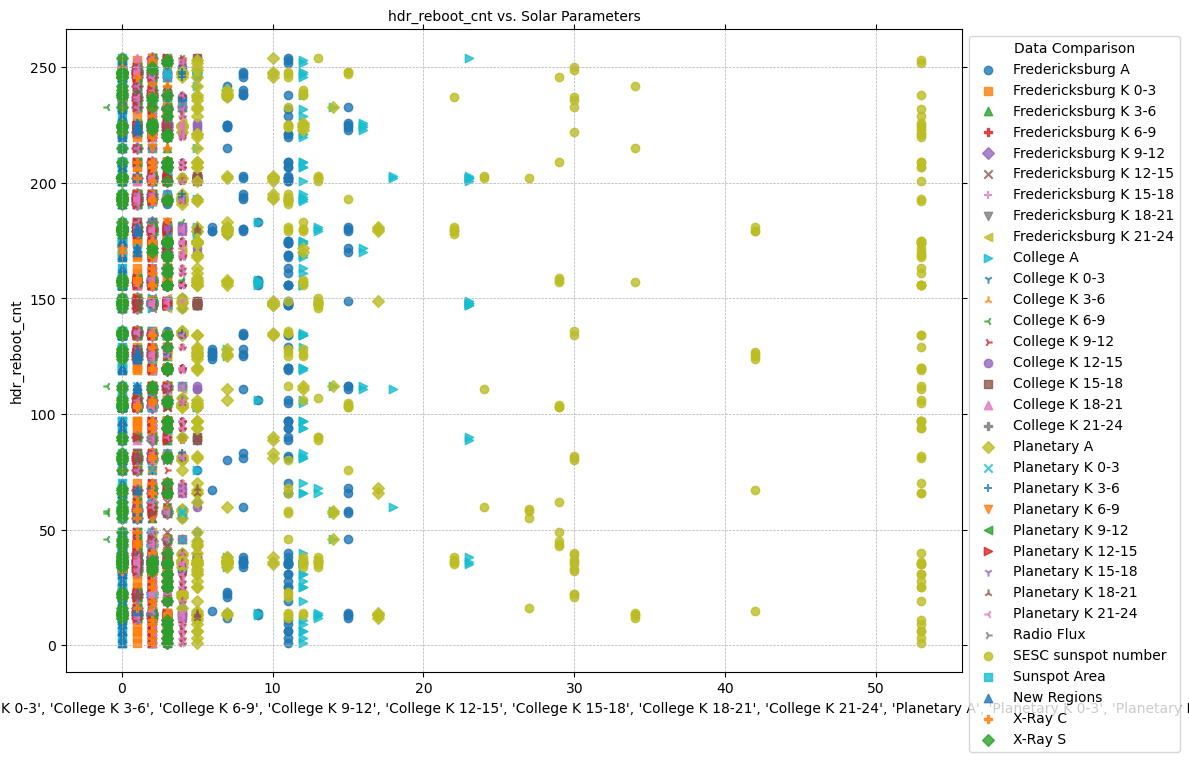

<Figure size 640x480 with 0 Axes>

In [37]:
def plot_sat_vs_solar(df: pd.DataFrame, sat_param_name: str,
                      solar_params_names: List[str],
                      figure_size=(12, 8), cmap='viridis',
                      legend_title='Data Comparison',
                      grid_style='--', grid_width=0.5, label_size=10):
    """
    Creates aesthetically pleasing and informative scatter plots for each satellite parameter
    vs. solar parameters, using advanced Matplotlib techniques for customization.

    Args:
        df (pd.DataFrame): DataFrame containing observations with timestamp index.
        sat_param_name (str): Name of the satellite parameter (y-axis).
        solar_params_names (list): List of solar parameter names (x-axes).
        figure_size (tuple, optional): Desired figure size. Defaults to (12, 8).
        cmap (str, optional): Colormap for scatter points (e.g., 'viridis', 'plasma'). Defaults to 'viridis'.
        legend_title (str, optional): Title for the legend. Defaults to 'Data Comparison'.
        grid_style (str, optional): Linestyle for the grid (e.g., '-', '--'). Defaults to '--'.
        grid_width (float, optional): Width of the grid lines. Defaults to 0.5.
        label_size (int, optional): Font size for labels and ticks. Defaults to 10.
    """
    figure, axis = plt.subplots(figsize=figure_size)

    # Define marker styles and cycle length
    markers = ['o', 's', '^', 'P', 'D', 'x', '+', 'v', '<', '>', '1',
               '2', '3', '4']  # More marker options for variety
    marker_cycle = itertools.cycle(markers)  # Cycle through markers

    y = df[sat_param_name].values
    for i, solar_param in enumerate(solar_params_names):
        x = df[solar_param].values
        axis.scatter(x, y, alpha=0.8, label=solar_param,
                     marker=next(marker_cycle))

    # Customization and informative labels
    axis.set_xlabel(f'{solar_params_names}', fontsize=label_size)
    axis.set_ylabel(sat_param_name, fontsize=label_size)
    axis.set_title(f"{sat_param_name} vs. Solar Parameters",
                   fontsize=label_size)
    axis.grid(True, which='both', linestyle=grid_style, linewidth=grid_width)
    axis.legend(loc='upper left', fontsize=label_size, title=legend_title,
                bbox_to_anchor=(1, 1))
    plt.tick_params(bottom=True, top=True, left=True, right=True, which='both',
                    labelsize=label_size)

    plt.tight_layout()
    plt.show()
    plt.clf()


for sat_param in satellite_parameters_names:
    logger.info(f"Plotting {sat_param} vs. Solar Parameters")
    plot_sat_vs_solar(observation_dataframe, sat_param,
                      solar_parameters_names.copy())

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
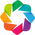

:DynamicMap   [x,y]
   :Scatter   [Fredericksburg A]   (hdr_opr_time)

In [38]:
import holoviews as hv
from holoviews import opts

hv.extension('bokeh')


def create_scatter_plot(df, x_columns, y_columns):
    """
    Creates an interactive scatter plot with HoloViews and Bokeh.
  
    Args:
        df (pd.DataFrame): Pandas DataFrame containing the data.
        x_columns (list): List of column names to use for the x-axis.
        y_columns (list): List of column names to use for the y-axis.
  
    Returns:
        HoloViews DynamicMap object: Interactive scatter plot.
    """

    def plot_func(x, y):
        return hv.Scatter(df, x, y).opts(
            opts.Scatter(tools=['hover'], size=8, color='blue')
        )

    return hv.DynamicMap(plot_func, kdims=['x', 'y']).redim.values(x=x_columns,
                                                                   y=y_columns)


plot = create_scatter_plot(observation_dataframe,
                           solar_parameters_names,
                           satellite_parameters_names
                           )

plot

In [39]:
from bokeh.embed import file_html
from bokeh.resources import CDN


def export_plot_to_html(plot, filename="../out/plot.html"):
    """
    Exports a HoloViews plot to a standalone HTML file using Bokeh.

    Args:
        plot (HoloViews object): The HoloViews plot to export.
        filename (str, optional): The name of the HTML file to create. Defaults to "plot.html".
    """
    # Render the plot using the Bokeh backend
    bokeh_plot = hv.render(plot, backend='bokeh')

    # Create the HTML file
    html = file_html(bokeh_plot, CDN, title="HoloViews Plot")

    # Save the HTML to a file
    with open(filename, "w") as f:
        f.write(html)


export_plot_to_html(plot)